<br>
<strong><center>Copyright 2021. Created by Mohamed Benaicha.</center></strong>

# Who's That Pokemon
Computer Vision Term Project

By: Mohamed Benaicha


**Introduction**: The 90s manga Pokemon has seen a revival like no other as of late with some of its collector cards clocking in at values of over USD 300 000. The entire manga is built around a set of animal-inspired creatures that befriend humans and become their "captured pets" - *ehhmm*. These pets are known as Pokemon and will be the interest of this computer vision project.


**Objective**: The objective of this project is to demonstrate the ability of deep learning to  recognize the Pokemon characters of Pikachu and Charizard which are probably every Pokemon lover's most coveted Pokemon.

So... what's a *Charizard* and what's a *Pikachu*?

This is a Charizard


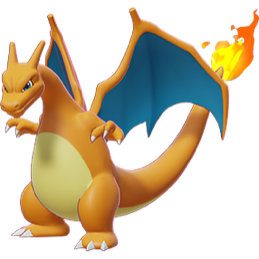

This is a Pikachu


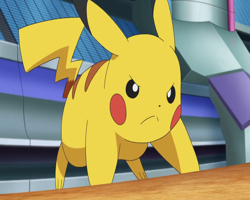

In [2]:
from PIL import Image
from IPython.display import display

with Image.open('Train/Charizard/006.png') as im1:
    print("This is a Charizard")
    display(im1)

with Image.open('Train/Pikachu/1200px-Ash_Pikachu.png') as im2:
    print("This is a Pikachu")
    display(im2.resize((250, 200)))


The **dataset** comproises 1,168 pictures of Charizard and Pikachu that I have scraped from Google images. The images are not distributed by me due to legal reasons including watermarked images.

The project demosntrates my ability to:
- collect images manually (through scraping)
- conduct transformations to synthetically enlarge the size of training data (given the limited resources to collect and manually label images)
- perform convolutions
- perform training of a deep convolutional neural network
- perform transfer learning using an existing deep neural net architecture (AlexNet in this case)

#### Data Sctructure

The script to scrape the images is in the same GitHub repo as this notebook. For that reason, that part of the code is omitted due to the space it takes up. Suffice it to say, the images were organized in the following directory parths and were in either jpeg or png formats:
<pre>.
└── Data
    └── Computer Vision Pictures Collection
        ├── Test
        │   ├── Pikachu
        │   │   ├── __.jpg
        │   │   ├── __.jpg
        │   │   └── ... (141 files)
        │   └── Charizard
        │       ├── __.jpg
        │       ├── __.jpg
        │       └── ... (129 files)       
        │           
        └── Train
            ├── Pikachu
            │   ├── __.jpg
            │   ├── __.jpg
            │   └── ... (449 files)
            └── Charizard
                ├── __.jpg
                ├── __.jpg
                └── ... (449 files)</pre>

In [5]:
import warnings
warnings.filterwarnings("ignore")

import os

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # torch vision utilities/models
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

## Section 1: Basic Convolution Nets

Thanks to the facility provided by the ImageFolder class from torch datasets, I can easily specify a source and a transformation that will be applied to the images that are organized in a directory in the fashion shown above to create train and test data splits to feed into the network as an interator object created through the DataLoader class.

### 1. a) Visualization/ preprocessing

In [6]:
# For our first attempt at training, we'll only resize and normalize images. 
# The following sections attempt things like rotations, flips and centre crops.

tr_trans_1 = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224), # resizing and cropping go hand in hand and are essental to keep the sizes consistent
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])]) # the normalizations concern 3 means and 3 stadnard deviations 
                                                  # correpsonding to the 3 colour channels of the image
                                                  # further, these values are commonly used in the literature and practice

te_trans_1 = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

# Specify path and train/test folder names
root = ''
tr_path = os.path.join(root, 'Train')
te_path = os.path.join(root, 'Test')


train_data = datasets.ImageFolder(tr_path, transform=tr_trans_1)
test_data = datasets.ImageFolder(te_path, transform=te_trans_1)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)


# Check out our classes and train/test sizes
print(train_data.classes)
display(len(train_data), len(test_data))

['Charizard', 'Pikachu']


898

270

Label: [1 0 0 0 0 0 1 1 1 1]
Class: Pikachu Charizard Charizard Charizard Charizard Charizard Pikachu Pikachu Pikachu Pikachu


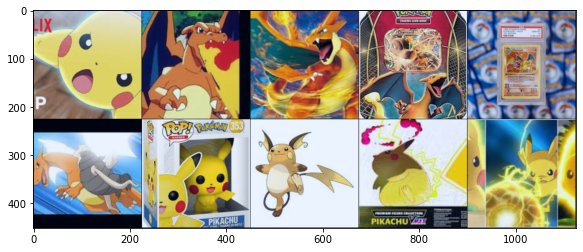

In [7]:
# Check out a group of images
for ims,classes in train_loader: 
    break

# Print the labels
print('Label:', classes.numpy())
print('Class:', *np.array([train_data.classes[i] for i in classes]))

im = make_grid(ims, nrow=5, padding=1, normalize=True)  # the default nrow is 8

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### 1. b) Modelling

In [190]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # ((input picture size + 2 * padding_size - kernel size)/stride size) + 1
        # do the above operation twice since we will be implicitly global max pooling 2d
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.fc1 = nn.Linear(54*54*12, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, X):
        '''
        The forward porpagation method.
        '''
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*12)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

Convolutional sizes are calculated as follows:

((input picture size + 2 * padding_size - kernel size)/stride size) + 1

Try it for yourself and see:

    import math
    x = ((224+0-3)/1)+1
    x = (x+0-2)/2 + 1
    x = ((x+0-3)/1)+1
    x = (x+0-2)/2 + 1
    math.floor(x) # round down

In [191]:
# instantiate, define loss (criterion), optimizer (for SGD) and display structure
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=34992, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

In [192]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>10}')
    print(f'__________\n{sum(params):>10}')
count_parameters(CNNmodel)

       162
         6
       648
        12
   1119744
        32
       512
        16
        32
         2
__________
   1121166


### 1. c) Training and evaluation


In [193]:
import time
start_time = time.time()

epochs = 20

max_trn_batch = 320
max_tst_batch = 160

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
#         print(torch.max(y_pred.data, 1)[1], y_train, (torch.max(y_pred.data, 1)[1] == y_train).sum())
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()

        trn_corr += batch_corr
        
        # Update parameters - through back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches with torch.no_grad() leaving the weights unupdated
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

train_losses = [i.item() for i in test_losses] 
test_losses = [i.item() for i in test_losses]
test_correct = [i.item() for i in test_correct]
train_correct = [i.item() for i in train_correct]


Duration: 169 seconds


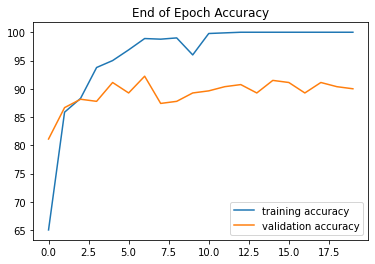

In [202]:
d1, d2 = len(train_data)/100, len(test_data)/100 # divisors given correct instances are 
plt.plot([t/d1 for t in train_correct], label='training accuracy')
plt.plot([t/d2 for t in test_correct], label='validation accuracy')
plt.title('End of Epoch Accuracy')
plt.legend();

We notice our model learns very quickly - after about 4 epochs - to distinguish between Pikachus and Charizards

Save the model, just in case...

In [203]:
torch.save(CNNmodel.state_dict(), 'SimpleImageCNNModel.pt')

In [204]:
# let's load it back for evaluation
model = ConvolutionalNetwork()
model.load_state_dict(torch.load('SimpleImageCNNModel.pt'))
model.eval() # set it to "evaluation mode", i.e. where weights aren't updated through back propagation

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=34992, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

I'll continue evaluating the model's test accuracy and also see where the model still errs.

In [205]:
preds = [model(test_data[i][0].reshape(1,test_data[i][0].shape[0], test_data[i][0].shape[1], test_data[i][0].shape[2])).argmax().item()  for i in range(len(test_data))]
actual = [test_data[i][1] for i in range(len(test_data))]

idxs, j = [], 0

# Using iteration to find
for i in preds:
    if i != actual[j]:
        idxs.append(j)
    j = j + 1
print(f"Model test accuracy: {(1-len(idxs)/len(test_data))*100} %")
print("Indices where the model erred: ", np.array(idxs).flatten())

Model test accuracy: 90.0 %
Indices where the model erred:  [ 18  34  44  75  91  95 136 145 163 169 174 175 176 177 182 190 194 200
 204 205 206 210 226 230 232 233 262]


Model predicts:  Pikachu
Actual label:  Charizard


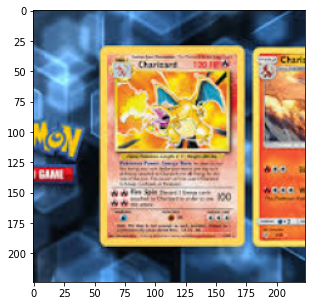

In [206]:
# Let's check some of those images out
i = 44
im = test_data[i][0]
label = test_data[i][1]
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

im = inv_normalize(im)
# Print the images
classes = train_data.classes
print("Model predicts: ", classes[model(test_data[i][0].reshape(1,test_data[i][0].shape[0], test_data[i][0].shape[1], test_data[i][0].shape[2])).argmax().item()])
print("Actual label: ", classes[test_data[i][1]])
plt.figure(figsize=(12,5))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### 1. d) Conluding remarks
Despite the high accuracy of our model, it still makes some crucial mistakes, such as labelling test image at index 145 a Charizard when it's clearly a Pikachu.

This demonstrates:
- the similzrity in colour of a Pikachu and a Charizard (yellow and orange respectively, we well as features including their pointy ears - perhaps - throws the model off slightly
- the complexity of dealing with real data that was collected and that isn't as well prepared as images found in most databases
- the noise in an image that can throw the model off (try i = 44)
- the need for more data, such as images, or image transformation, to help our models avoid such seemingly easy-to-avoid mistakes.

## Section 2: Convolution Nets with Image Transformations

### 2. a) Visualization/ preprocessing

Here I'll add new transformations to "expand" the size of our training data (and not the testing data!)

In [213]:
tr_trans_2 = transforms.Compose([
    transforms.RandomRotation(30),      
    transforms.RandomHorizontalFlip(),  
    transforms.Resize(224),             
    transforms.CenterCrop(224),         
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

# NOTE! Testing data isn't rotated/flipped...
te_trans_2 = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])


train_data = datasets.ImageFolder(tr_path, transform=tr_trans_2)
test_data = datasets.ImageFolder(te_path, transform=te_trans_2)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

Check out what the transformations have done:

Label: [0 0 0 0 1 0 1 0 1 0]
Class: Charizard Charizard Charizard Charizard Pikachu Charizard Pikachu Charizard Pikachu Charizard


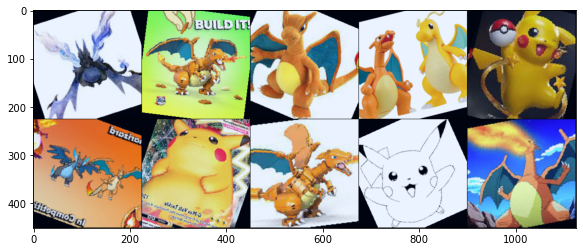

In [214]:
# Check out a group of images
for ims,classes in train_loader: 
    break

# Print the labels
print('Label:', classes.numpy())
print('Class:', *np.array([train_data.classes[i] for i in classes]))

im = make_grid(ims, nrow=5, padding=1, normalize=True)  # the default nrow is 8

# Inverse normalize the images (could use: normalize=True in make grid)
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### 2. b) Modelling

I'll use the same convolution net as before

In [215]:
# instantiate, define loss (criterion), optimizer (for SGD) and display structure
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=34992, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

### 2. c) Training and evaluation 

In [217]:
import time
start_time = time.time()

epochs = 20

max_trn_batch = 320
max_tst_batch = 160

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
#         print(torch.max(y_pred.data, 1)[1], y_train, (torch.max(y_pred.data, 1)[1] == y_train).sum())
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()

        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

train_losses = [i.item() for i in test_losses] 
test_losses = [i.item() for i in test_losses]
test_correct = [i.item() for i in test_correct]
train_correct = [i.item() for i in train_correct]


Duration: 175 seconds


Slightly longer to train, but did it improve test accuracy? It sure seems like it.

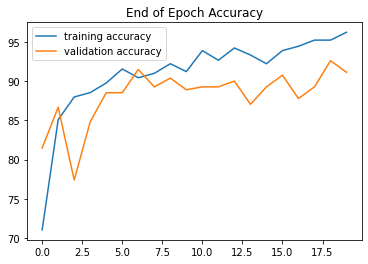

In [220]:
d1, d2 = len(train_data)/100, len(test_data)/100 # divisors given correct instances are 
plt.plot([t/d1 for t in train_correct], label='training accuracy')
plt.plot([t/d2 for t in test_correct], label='validation accuracy')
plt.title('End of Epoch Accuracy')
plt.legend();

In [221]:
torch.save(CNNmodel.state_dict(), 'SimpleImageCNNModel_withTransforms.pt')
# let's load it back for evaluation
model = ConvolutionalNetwork()
model.load_state_dict(torch.load('SimpleImageCNNModel_withTransforms.pt'))
model.eval() # set it to "evaluation mode", i.e. where weights aren't updated through back propagation

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=34992, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

In [222]:
preds = [model(test_data[i][0].reshape(1,test_data[i][0].shape[0], test_data[i][0].shape[1], test_data[i][0].shape[2])).argmax().item()  for i in range(len(test_data))]
actual = [test_data[i][1] for i in range(len(test_data))]

idxs, j = [], 0

# Using iteration to find
for i in preds:
    if i != actual[j]:
        idxs.append(j)
    j = j + 1
print(f"Model test accuracy: {(1-len(idxs)/len(test_data))*100} %")
print("Indices where the model erred: ", np.array(idxs).flatten())

Model test accuracy: 91.11111111111111 %
Indices where the model erred:  [ 59  65  95 107 113 114 136 145 155 157 169 174 175 182 190 194 200 205
 221 224 226 232 233 262]


A slight improvement in the test accuracy as a result of the transformations, not bad!

Model predicts:  Pikachu
Actual label:  Charizard


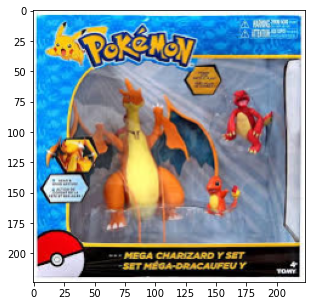

In [225]:
# Let's check some of the images where our model erred
i = 107
im = test_data[i][0]
label = test_data[i][1]
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

im = inv_normalize(im)
# Print the images
classes = train_data.classes
print("Model predicts: ", classes[model(test_data[i][0].reshape(1,test_data[i][0].shape[0], test_data[i][0].shape[1], test_data[i][0].shape[2])).argmax().item()])
print("Actual label: ", classes[test_data[i][1]])
plt.figure(figsize=(12,5))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

A similar conclusion as that of the Section 1 can be drawn for this section. In the above image, both a Charizard and Pikachu exist in a single image, hence a multi-object detection model could have detected them both, but my network is trained only on single object detection.

## Section 3: Transfer learning using AlexNet

### 3. a) Modelling

AlexNet can be accessed here: <a href="https://arxiv.org/abs/1404.5997">AlexNet</a>


The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. The three values represent the RBG colour channels.


In [226]:
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

I'll first try training with every convolutional layer of AlexNet frozen

In [228]:
for param in AlexNetmodel.parameters(): param.requires_grad = False

I'll add a classification layer on top of the convolutional blocks of AlexNet

In [230]:
# AlexNet's convolutional blocks output a final vector of features of length 4096 and 4096 which add up to 9216 
# due to adaptive average 2d pooling so we'll specifyy that as the input to our classifier
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 512),
                                 nn.ReLU(),
#                                  nn.Dropout(0.4),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_featur

In [232]:
# These are the TRAINABLE parameters:
count_parameters(AlexNetmodel)

   4718592
       512
      1024
         2
__________
   4720130


In [233]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

### 3. b) Training and evaluation

Remember, we're only training the fully connected layers. The convolutional layers have fixed weights and biases. For this reason, we need to run it for a smaller number of epochs.

In [235]:
import time
start_time = time.time()

epochs = 5

max_trn_batch = 320
max_tst_batch = 160

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

train_losses = [i.item() for i in test_losses] 
test_losses = [i.item() for i in test_losses]
test_correct = [i.item() for i in test_correct]
train_correct = [i.item() for i in train_correct]


Duration: 65 seconds


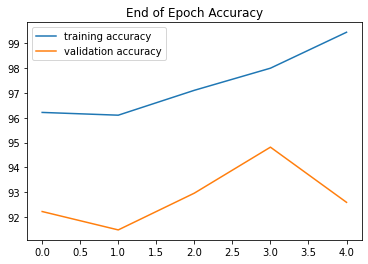

In [236]:
d1, d2 = len(train_data)/100, len(test_data)/100 # divisors given correct instances are 
plt.plot([t/d1 for t in train_correct], label='training accuracy')
plt.plot([t/d2 for t in test_correct], label='validation accuracy')
plt.title('End of Epoch Accuracy')
plt.legend();

As suspected, after 5 epochs, training accuracy is maxed out. The only learning of concern was classification and not convolutions given we used a pretrained network. We could have also applied early stopping by saving the model's state dictionary whenever a higher validation accuracy was attained.

In [241]:
torch.save(AlexNetmodel.state_dict(), 'AlexNet_withTransforms.pt')
# let's load it back for evaluation
AlexNetmodel.load_state_dict(torch.load('AlexNet_withTransforms.pt'))
AlexNetmodel.eval() # set it to "evaluation mode", i.e. where weights aren't updated through back propagation

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_featur

In [242]:
preds = [AlexNetmodel(test_data[i][0].reshape(1,
                                              test_data[i][0].shape[0], 
                                              test_data[i][0].shape[1], 
                                              test_data[i][0].shape[2])).argmax().item()  
                                              for i in range(len(test_data))]
actual = [test_data[i][1] for i in range(len(test_data))]

idxs, j = [], 0

# Using iteration to find
for i in preds:
    if i != actual[j]:
        idxs.append(j)
    j = j + 1
print(f"Model test accuracy: {(1-len(idxs)/len(test_data))*100} %")
print("Indices where the model erred: ", np.array(idxs).flatten())

Model test accuracy: 92.5925925925926 %
Indices where the model erred:  [ 96 129 135 136 157 174 175 176 178 182 186 200 205 224 227 236 237 247
 257 263]


**Even more improvement with transfer learning, impressive.**

Model predicts:  Charizard
Actual label:  Pikachu


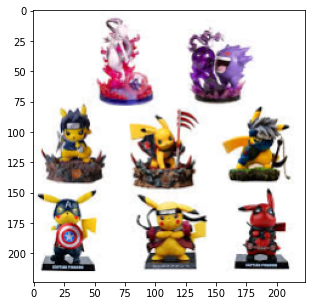

In [245]:
# Let's check some of the images where our model erred
i = 157
im = test_data[i][0]
label = test_data[i][1]
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

im = inv_normalize(im)
# Print the images
classes = train_data.classes
print("Model predicts: ", classes[AlexNetmodel(test_data[i][0].reshape(1,test_data[i][0].shape[0], test_data[i][0].shape[1], test_data[i][0].shape[2])).argmax().item()])
print("Actual label: ", classes[test_data[i][1]])
plt.figure(figsize=(12,5))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

The model will still ultimately run into mistakes due ot the limited number of images and the difficulty of classifying such images.

Test image at index 157 that is displayed above for example features 8 models of Pikachu which the network didn't know how to work with and mistakenly labelled as a Charizard. Naturally, the model is trained to recognize one Pokemon figure at a time - i.e. single object detection. Given the noise that exists in the image, its prediction was probably a random guess.

## Conclusion


**Data collection**: The images demonstrate a real image dataset that i've collected and - given limited time - cleaned to the bes tof my ability. The images collected were sufficient for good classification accuracy but not enough in number for excellent classification accuracy.

**Preprocessing**: transforming the images did help improve training, but not as much as one would like given the model could already classify the two Pokemon characters quite well with the existing untransformed images. Cropping was necessary given the large variation in image sizes since these images were scraped in batches off of Google.

**Modelling**: the CNNs or pretrained networks used are large given the size of my dataset which was demonstrated by the fact that the model was overfit during training but maintianed its validatio accuracy at a good level.

**Evaluation** the models perofored well on test data achieving roughly over 90% test accuracies. The errors made by themodels however were also quite surprising given some of the images features depictions of Pikachu and Charizard that are easy to discern. Despite all that, some images on which the model erred featured a lot of noise such as multiple figures (objects) in a single image throwing the model off completely as it was trained on images with a single figure.
